# Random Forest (score ~ 0.305)
## MLP2 - Team 0rel - Bozzo

In [ ]:
import nibabel as nib
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt,atan2,pi,ceil,acos,sin,cos
from sklearn.metrics import log_loss

from orelmisc import n_max,n_test_max,testpre,trainpre,saveCSV,y_org,shape_3d_org
from preprocess import flatten,flatten_each_sample,loadData,flatten_each_sample,precompute_and_save

In [12]:
prep_ = lambda i: cap(i) #if i < 0.9 else 1 # round up at 0.8 improves score :)
def prep(a):
  return map(prep_,a)

cap = lambda p: min(1,max(0,p))
def pred_to_rgb(p):
  p = cap(p)
  v = p
  return (1-v,v,0.2)

x_org = None
x_t_org = None
xa_org = None
d_org = None
y = np.array(y_org)
y_mean = np.full(n_max,np.mean(y),dtype=np.float64)[:n_test_max]
y_t_pred = None
yts_pred = None
y_t_pp = None
prefix=None
alpha = 10
result = None
xa = []
x = None
x_t = None
TO_RADIANS = pi/180

In [13]:
space = 70 #35 # 35,50,70,100,150
bins = np.linspace(1,1700,space)
hSize = space-1
r_division = 6
theta_division = 4
phi_division = 6
ranges = [1,r_division,theta_division,phi_division]
nHists = r_division*theta_division*phi_division

name = "output/"+str(space)+"_split_validated"
fname = "many_hists"+str(nHists)+"_space" + str(space) + ("_divs_%s_%s_%s.npy" % (r_division,theta_division,phi_division))
fnameSpherical = "spherical_every2.npy"
fnameMeanHist = "mean_hist" + str(space) + ".npy"
fnameMeanHists = "mean_hists" + str(space) + ".npy"

xStats = np.load("statistics_diff_hist200.npy")
xSpherical = np.load(fnameSpherical)
nPercentiles = 20
bStat = 7
sbins = bins[:-1]+1800/space/2
ds = bStat + nPercentiles + nHists*hSize # sum,sum2,sum3,avg,var,mode, numper of percentiles and histograms
iHist = bStat + nPercentiles
idxHist = lambda i: iHist+i*hSize

# radius form 0 to 80
# theta from 0 to 180
# phi from 0 to 360
rMax = 80
tMin = 30
tMax = 180-tMin

print "Number of Histograms:",nHists
print "Size of Histograms:",hSize
print "Dimensions: ca.",nHists*hSize

Number of Histograms: 144
Size of Histograms: 69
Dimensions: ca. 9936


In [16]:
def spherical2cart(r,theta,phi):
  return (r*sin(theta)*cos(phi),r*sin(theta)*sin(phi),r*cos(theta))

fromto = lambda di,sph: zip(np.round(np.linspace(0,sph.shape[di],ranges[di]+1)),np.round(np.linspace(0,sph.shape[di],ranges[di]+1))[1:])

# the code commented out in "loadAndPreprocess()" was used to transform the images into spherical coordinates
# We didn't supply the .npy file for the spherical coordinates, since it takes ~1h to compute and is a few GBs large.
# since we don't need it for the prediction itself anymore, we just provide the features data file. (many_hists144_space70_divs_6_4_6.npy)
def loadAndPreprocess():
    global d_org,x,x_t,xa,x_org,x_t_org,xa_org,xSpherical
    
    xa = np.zeros((n_max+n_test_max,ds))
    #xSpherical = np.zeros((n_max+n_test_max,rMax/2+1,(tMax-tMin)/2+1,360/2+1))
    
    i = 0
    #print "===== Calculate spherical coordiantes ===="
    
    while i < n_max+n_test_max:
      if i % 6 == 0:
        print "  i = %s ... %.1f%%" % (i,float(i)/(n_max+n_test_max)*100)
      
      n_i,pre,t_str = (n_max,"set_train/","train") if i < n_max else (n_test_max,"set_test/","test")
      filename = "%s%s_%s.nii" % (pre,t_str,i%n_max+1)
      Xtotal,Ytotal,Ztotal = (176,208,176)
      data = nib.load(filename).get_data().reshape((Xtotal,Ytotal,Ztotal))
      
      """Calculate zoomed spherical representation, needs 3 seconds
      for r in np.linspace(0,rMax,rMax/2+1):
        for theta in np.linspace(tMin,tMax,(tMax-tMin)/2+1):
          for phi in np.linspace(0,360,360/2+1):
            x,y,z = spherical2cart(r,theta*TO_RADIANS,phi*TO_RADIANS)
            x = x + Xtotal/2
            y = y + Ytotal/2
            z = z + Ztotal/2
            if 0 <= x < Xtotal and 0 <= y < Ytotal and 0 <= z < Ztotal:
              xSpherical[i,r/2,(theta-tMin)/2,phi/2] = data[int(x),int(y),int(z)]"""

      # calculate histograms: 8*4*8 = 256 histograms
      hCount = 0
      for l,u in fromto(1,xSpherical):
        l0,u0=(int(l),int(u))
        for l,u in fromto(2,xSpherical):
          l1,u1=(int(l),int(u))
          for l,u in fromto(3,xSpherical):
            l2,u2=(int(l),int(u))
            cut = xSpherical[i,l0:u0,l1:u1,l2:u2]
            h=np.histogram(cut.ravel(),bins=bins)[0]
            xa[i,(iHist+(hCount*hSize)):(iHist+(hCount+1)*hSize)] = h
            hCount = hCount + 1
      
      xa[i,:iHist] = xStats[i,:iHist] # copy statistics from precomputation
      i = i+1
    
    np.save(fname,xa)
    print "======= Saved data matrix xa into %s =========" % fname
    
    #np.save(fnameSpherical,xSpherical)
    #print "======= Saved spherical coordinates into %s =========" % fnameSpherical

if False:
  loadAndPreprocess()
else:
  xa = np.load(fname)
  x,x_t = (xa[0:n_max,:],xa[n_max:,:])

In [29]:
from sklearn.model_selection import train_test_split
# xa. all data
# x. public training data
# y. public training targets
# x_t public to be predicted data

# xtr. training data
# ytr. training targets
# xts. validation data
# yts. validation targets

# indices for splitting
ones = np.array(filter(lambda i: y[i]==1,range(0,n_max)))
zeros = np.array(filter(lambda i: y[i]==0,range(0,n_max)))
# split the indices
onestr,onests,_,_ = train_test_split(ones,ones*0,test_size=0.3,random_state=1)
zerostr,zerosts,_,_ = train_test_split(zeros,zeros*0,test_size=0.3,random_state=1)

# plot the data. a few random states have been tried to to make sure all splits are balanced enough.
print "Indices for total data: "
print "  healthy",len(ones),": ",ones[5:15],"..."
print "  sick",len(zeros),": ",zeros[5:15],"...\n"

print "Indices for splitted data: "
print "  healthy training ",len(onestr),": ",onestr[5:15],"..."
print "  healthy test ",len(onests),": ",onests[5:15],"..."
print "  sick training ",len(zerostr),": ",zerostr[5:15],"..."
print "  sick test ",len(zerosts),": ",zerosts[5:15],"..."

xtr = np.vstack((x[onestr],x[zerostr]))
xts = np.vstack((x[onests],x[zerosts]))
ytr = np.hstack((y[onestr],y[zerostr]))
yts = np.hstack((y[onests],y[zerosts]))

print "\nSplitted data into test and validation data"

Indices for total data: 
  healthy 211 :  [ 5  6  7  9 10 11 12 14 18 19] ...
  sick 67 :  [27 30 36 37 48 51 54 55 58 60] ...

Indices for splitted data: 
  healthy training  147 :  [123 198  98 149  53  22   5 208 228  63] ...
  healthy test  64 :  [111  42 200 271 171 119   4  62  23  76] ...
  sick training  46 :  [161 121  37  77 225 255 242 206 229 261] ...
  sick test  21 :  [158  15 181 197 143 249 177 241 194 167] ...

Splitted data into test and validation data


In [19]:
def randomForest(n_est,f,msp,max_depth,histMin,histMax):
  global y_t_pred,yts_pred,result,y_t_pp
  prefix = "%s_RandomForest_histMin%s_histMax%s_n%s_feats%s_msp%s_max_depth%s"%(name,histMin,histMax,n_est,f,msp,max_depth)
  print "Prediction with %s" % prefix
  model = RandomForestRegressor(n_est,max_features=f,min_samples_split=msp,max_depth=max_depth,random_state=1)
  xtr1 = xtr[:,idxHist(histMin):idxHist(histMax)] # use all data
  xts1 = xts[:,idxHist(histMin):idxHist(histMax)] # use all data
  x_t1 = x_t[:,idxHist(histMin):idxHist(histMax)]
  yts_pred = model.fit(xtr1,ytr).predict(xts1)
  y_t_pred = model.predict(x_t1)
  
  y_t_pp = prep(y_t_pred)
  yts_pp = prep(yts_pred)
  ytr_pp = prep(model.predict(xtr1))
  ltr = log_loss(ytr,ytr_pp)
  lts = log_loss(yts,yts_pp)
  ltm = log_loss(yts,y_mean[:len(yts)])
  print("\n")
  print("============================    Log-Loss train           ltr = %.3f =========="%ltr)
  print("============================    Log-Loss test            lts = %.3f =========="%lts)
  print("============================    Log-Loss mean prediciton ltm = %.3f ==========\n\n"%ltm)
  trCorrect = len(map(lambda x:x[0]-x[1],filter(lambda x:x[0]!=x[1],zip(ytr,ytr_pp))))
  tsCorrect = len(map(lambda x:x[0]-x[1],filter(lambda x:x[0]!=x[1],zip(yts,yts_pp))))
  print "Predictions training: %s correct / %s incorrect" %(trCorrect,len(xtr)-trCorrect)
  print "Predictions validation: %s correct / %s incorrect" %(tsCorrect,len(xts)-tsCorrect)
  print "Score: " % model.score(xts1,yts)
  prefix = "%s_expected_score%.3f"%(prefix,lts)
  return prefix,model

In [20]:
def doStuff(n_est=400,f=0.15,msp=10,max_depth=3,hmin=0,hmax=40):
  global prefix,result
  
  prefix,model = randomForest(n_est=n_est,f=f,msp=msp,max_depth=max_depth,histMin=hmin,histMax=hmax)
  
  savePrediction()
  
  visualize(y,y_t_pp,prefix)
  
  print "Variables available in 'result'"
  result = (x,y,x_t,y_t_pred,y_t_pp,model)

def visualize(y,y_t_pp,prefix):
  plt.clf()
  plt.plot(np.array(y_t_pp),"bo")
  plt.savefig(prefix + "_predictions.png")
  plt.show()
  plt.clf()
  plt.title("PREDICTIONS sorted (0=unhealty, 1=healthy)")
  plt.plot(sorted(y_t_pp),"bo")
  plt.savefig(prefix + "_plot.png")
  print("Saved age diagrams as %s"%(prefix+"*.png"))
  plt.show()

def savePrediction():
    savedFilename = saveCSV(map(cap,y_t_pp),prefix)
    print("Saved predictions into %s" % savedFilename)

Prediction with output/70_split_validated_RandomForest_histMin0_histMax144_n500_feats0.2_msp10_max_depth2


============================    Log-Loss train           ltr = 0.157 ==========
============================    Log-Loss test            lts = 0.303 ==========
============================    Log-Loss mean prediciton ltm = 0.559 ==========


Predictions training: 193 correct / 0 incorrect
Predictions validation: 85 correct / 0 incorrect
Score: 
Saved predictions into output/70_split_validated_RandomForest_histMin0_histMax144_n500_feats0.2_msp10_max_depth2_expected_score0.303.csv


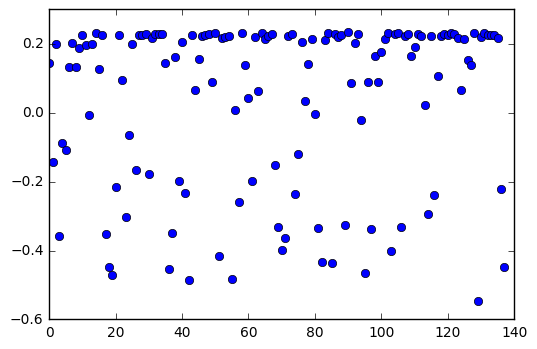

Saved age diagrams as output/70_split_validated_RandomForest_histMin0_histMax144_n500_feats0.2_msp10_max_depth2_expected_score0.303*.png


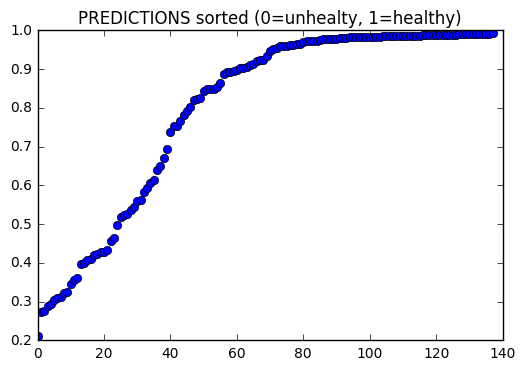

Variables available in 'result'


In [21]:
doStuff(n_est=500,f=0.2,msp=10,max_depth=2,hmin=0,hmax=nHists)

0.0


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


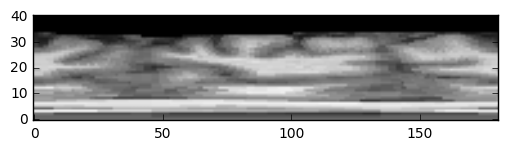

9.375


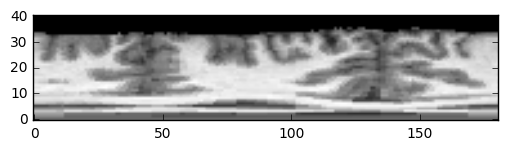

18.75


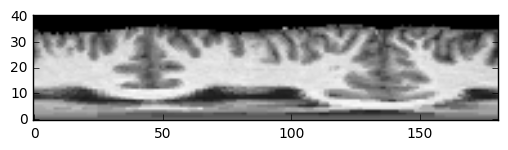

28.125


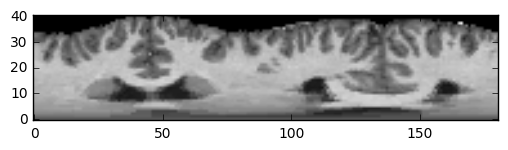

37.5


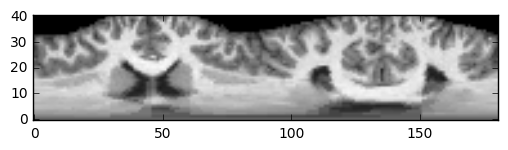

46.875


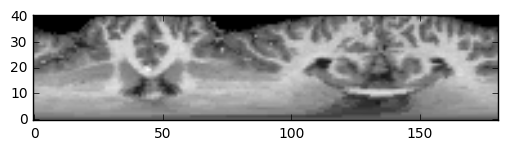

56.25


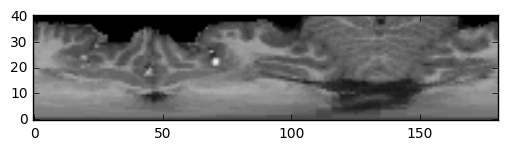

65.625


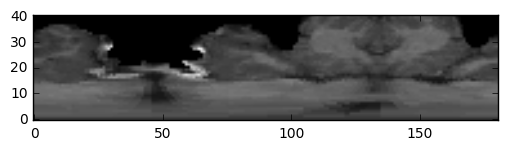

75.0


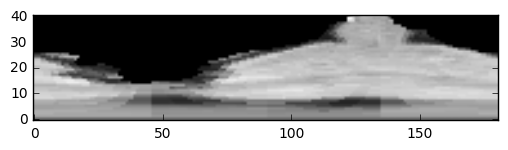

In [22]:
if True:
  i = 413
  for theta in np.linspace(0,xSpherical[i].shape[1]-1,9):
    print theta
    plt.imshow(xSpherical[i,:,theta,:], cmap="gray", origin="lower")
    plt.show()

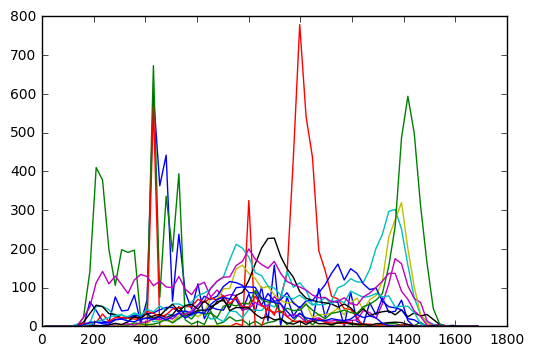

In [26]:
#plt.plot(xa[4,:])
#plt.show()
for i in np.linspace(0,nHists-1,15):
  i = int(i)
  k = xa[12,(iHist+i*hSize):(iHist+(i+1)*hSize)]
  plt.plot(sbins,k)
plt.show()